In [1]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Apache Beam RunInference with TensorFlow and TensorFlow Hub

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/beam-ml/run_inference_with_tensorflow_hub.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/colab_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/run_inference_with_tensorflow_hub.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/github_32px.png" />View source on GitHub</a>
  </td>
</table>


This notebook shows how to use the Apache Beam [RunInference](https://beam.apache.org/releases/pydoc/current/apache_beam.ml.inference.base.html#apache_beam.ml.inference.base.RunInference) transform for [TensorFlow](https://www.tensorflow.org/) with a trained model from [TensorFlow Hub](https://www.tensorflow.org/hub).
Apache Beam includes built-in support for two TensorFlow model handlers: [TFModelHandlerNumpy](https://github.com/apache/beam/blob/ca0787642a6b3804a742326147281c99ae8d08d2/sdks/python/apache_beam/ml/inference/tensorflow_inference.py#L91) and [TFModelHandlerTensor](https://github.com/apache/beam/blob/ca0787642a6b3804a742326147281c99ae8d08d2/sdks/python/apache_beam/ml/inference/tensorflow_inference.py#L184).

* Use `TFModelHandlerNumpy` to run inference on models that expect a NumPy array as an input.
* Use `TFModelHandlerTensor` to run inference on models expecting a tensor as an input.

For more information about using RunInference, see [Get started with AI/ML pipelines](https://beam.apache.org/documentation/ml/overview/) in the Apache Beam documentation.

**Note:** The image used for prediction is licensed in CC-BY. The creator is listed in the [LICENSE.txt](https://storage.googleapis.com/apache-beam-samples/image_captioning/LICENSE.txt) file.

## Before you begin
First, import `tensorflow`. To use RunInference with the TensorFlow model handler, install Apache Beam version 2.46 or later.

In [ ]:
!pip install tensorflow
!pip install apache_beam==2.46.0

## Use TensorFlow Hub's trained model URL
To use TensorFlow Hub's trained model URL, pass the model URL to the `model_uri` field of `TFModelHandler` class.

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import apache_beam as beam

In [4]:
# URL of the trained model from TensorFlow Hub
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

1812110/1812110 [==============================] - 0s 0us/step


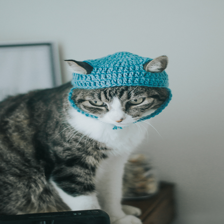

In [5]:
import numpy as np
import PIL.Image as Image

IMAGE_RES = 224
img = tf.keras.utils.get_file(origin='https://storage.googleapis.com/apache-beam-samples/image_captioning/Cat-with-beanie.jpg')
img = Image.open(img).resize((IMAGE_RES, IMAGE_RES))
img

In [6]:
# Convert the input image to the type and dimensions required by the model.
img = np.array(img)/255.0
img_tensor = tf.cast(tf.convert_to_tensor(img[...]), dtype=tf.float32)

In [8]:
from apache_beam.ml.inference.tensorflow_inference import TFModelHandlerTensor
from apache_beam.ml.inference.base import PredictionResult
from apache_beam.ml.inference.base import RunInference
from typing import Iterable

model_handler = TFModelHandlerTensor(model_uri=CLASSIFIER_URL)

class PostProcessor(beam.DoFn):
  """Process the PredictionResult to get the predicted label.
  Returns predicted label.
  """
  def setup(self):
    labels_path = tf.keras.utils.get_file(
        'ImageNetLabels.txt',
        'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
    )
    self._imagenet_labels = np.array(open(labels_path).read().splitlines())

  def process(self, element: PredictionResult) -> Iterable[str]:
    predicted_class = np.argmax(element.inference)
    predicted_class_name = self._imagenet_labels[predicted_class]
    yield "Predicted Label: {}".format(predicted_class_name.title())

with beam.Pipeline() as p:
  _ = (p
    | "Create PCollection" >> beam.Create([img_tensor])
    | "Perform inference" >> RunInference(model_handler)
    | "Post Processing" >> beam.ParDo(PostProcessor())
    | "Print" >> beam.Map(print))

Predicted Label: Tiger Cat
